In [1]:
import numpy as np
import matplotlib.pyplot as plt
import models as mod
import mod_visualization as mv

%load_ext autoreload
%autoreload 2

Logger not found, using fake logger


In [2]:
from IPython.display import clear_output
def clf():
    clear_output(wait=True)

# 1D
---

**Settings**

In [176]:
N = 10
Nj = 20
T = 20*1000

## Input

In [177]:
# input spikes
Sj = np.random.binomial(1, 10/1000, size=(T, Nj, 1))

bin_size = 1500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.binomial(1, 300/1000, size=(bin_size, 1))
    i += 1
    j += 1

In [246]:
# input spikes
Sj = np.random.normal(0, 0.1, (T, Nj, 1)).clip(0, 1)

bin_size = 500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.normal(0, 1., size=(bin_size, 1)).clip(0, 1)
    i += 1
    j += 1

## Model 

In [320]:
net = mod.Network(N=N, Nj=Nj, learnable=True, lr=3e-2, 
                  wr_const=3.75,
                  wff_const=5.5,
                  wff_max=4.,
                  wff_min=0.1,
                  wff_beta=0.02,
                  wff_tau=50,
                  wr_tau=75,
                  tau_u=55,
                  syn_ff_min=0.04,
                 )

Network(N=10, Nj=20)


#### Connectivity

Recurrent weights set (10, 10)


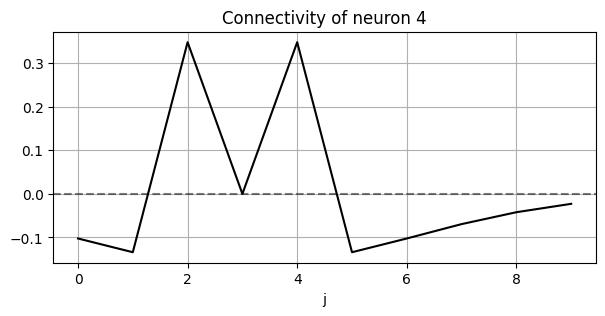

In [321]:
w = mod.mexican_hat_1D(N=N, A=1., B=.045, sigma_exc=.5, sigma_inh=3)

net.set_wrec(w)
#mv.plot_weight_matrix(net.Wrec)

plt.figure(figsize=(7, 3))
plt.axhline(0, color="black", alpha=0.5, linestyle='--')
plt.plot(range(N), net.Wrec[3], '-k')
plt.title("Connectivity of neuron 4")
plt.xlabel("j")
plt.grid()
plt.show()

In [322]:
net.Wrec.max()

0.347876651759281

## Simulation

In [324]:
net.reset()

tp = 200

sp = np.zeros(Nj)
for t in range(T):

    net.step(Sj=Sj[t])
    sp += Sj[t, :, 0]

    #plt.clf()
    if t%tp == 0:
        clf()
        fig = plt.figure(figsize=(15, 7))

        plt.subplot(221)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 1], 'v')
        plt.ylim((-10, 15))
        plt.grid()
        plt.xticks(range(N))
        plt.title("Recurrent input")

        plt.subplot(222)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 2], 'v')
        plt.ylim((-10, 10))
        plt.grid()
        plt.xticks(range(N))
        plt.title("last neuron, $I_{rec}$="+f"{net.record[:, 2].sum():.3f}")

        plt.subplot(212)
        plt.plot(range(Nj), sp / (t+1) * 10, 'ok', alpha=0.3)

        for i in range(N):
            plt.plot(range(Nj), net.Wff[i], alpha=0.8, color=net.colors[i],
                     label=f"$lr$={net._lr[i, 0]:.4f}")
        plt.xlabel("Wff")
        plt.title(f"t={t+tp}ms | $w_M$={net.wff_max}")
        plt.ylim((0, 5.5))
        plt.xticks((range(Nj)))
        plt.legend(loc="upper right")
        plt.pause(0.01)

print(".")

KeyboardInterrupt: 

In [314]:
net.record[:, 1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# 2D
---

**Settings**

In [335]:
N = 10
Nj = 25
T = 10 # 1 step/s

## Inputs

move  down   (2, 1)
move  down   (2, 0)
- !down, new:  ['left', 'right']
-- new choices:  ['left', 'right']
move  left   (1, 0)
- !down, new:  ['up', 'left']
-- new choices:  ['up', 'left']
move  left   (0, 0)
- !left, new:  ['up', 'down']
-- new choices:  ['up', 'down']
move  up   (0, 1)
move  right   (1, 1)
move  up   (1, 2)
move  up   (1, 3)
move  right   (2, 3)
move  down   (2, 2)


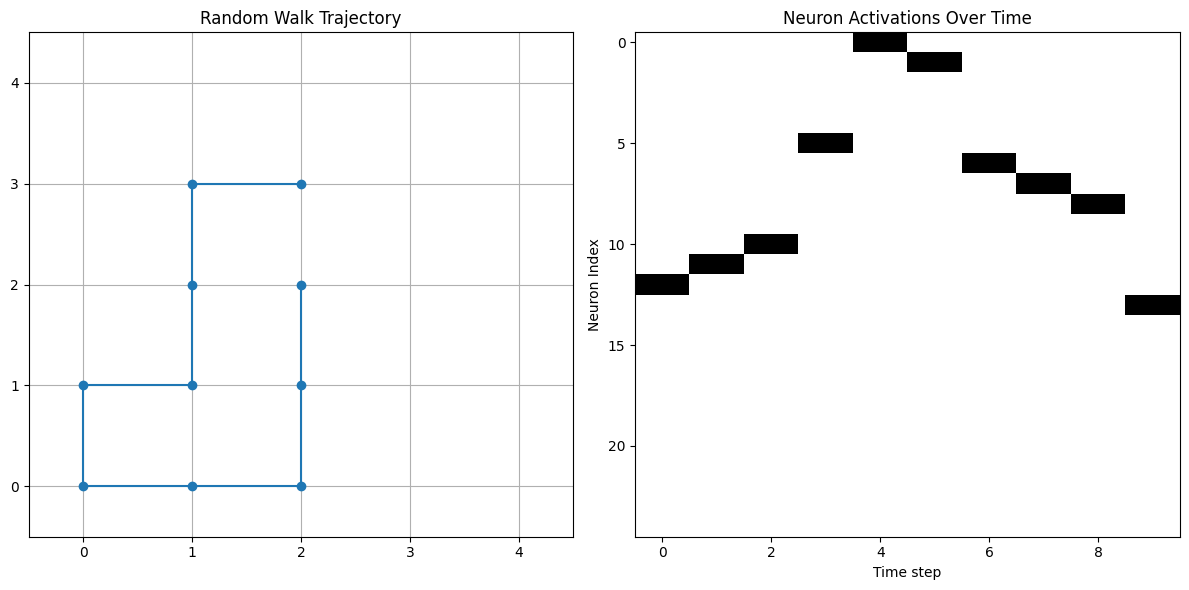

Trajectory: [(2, 2), (2, 1), (2, 0), (1, 0), (0, 0), (0, 1), (1, 1), (1, 2), (1, 3), (2, 3)]
Activations shape: 10, (25,)


In [336]:
def generate_walk_trajectory(N, steps):

    """Generate a continuous forward-only walk trajectory in an N x N grid."""
    
    trajectory = []
    activations = []
    position = (N // 2, N // 2)  # Start from the center of the grid

    # Define the previous move to avoid staying in the same spot or moving back
    prev_move = None

    for _ in range(steps):
        trajectory.append(position)
        activation = np.zeros((N, N))
        activation[position] = 1
        activations.append(activation.flatten())

        # Define possible moves and remove the opposite of the previous move to avoid going back or staying
        possible_moves = ['up', 'down', 'left', 'right']
        if prev_move:
            opposite_moves = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
            # Remove the opposite move of the previous one
            possible_moves.remove(opposite_moves[prev_move])

        # Choose a random direction from the remaining possible moves
        move = random.choice(possible_moves)
        #if move == prev_move:
        #    print(move, prev_move, possible_moves)
        prev_move = move  # Update the previous move

        # Move to the new position based on the chosen move

        # UP
        done = False

        while not done:
            if move == 'up' and position[1] < N-1:  # legal
                position = (position[0], position[1] + 1)
                done = True
            elif move == 'up' and position[1] >= N: # illegal
                possible_moves = [s for s in possible_moves if s != 'up']
                print('- !up, new: ', possible_moves)
        
            # Down
            if move == 'down' and position[1] > 0:  # legal
                position = (position[0], position[1] - 1)
                done = True
            elif move == 'down' and position[1] <= 0: # illegal
                possible_moves = [s for s in possible_moves if s != 'down']
                print('- !down, new: ', possible_moves)
        
            # Left
            if move == 'right' and position[0] < N-1:  # legal
                position = (position[0]+1, position[1])
                done = True
            elif move == 'right' and position[0] >= N: # illegal
                possible_moves = [s for s in possible_moves if s != 'right']
                print('- !up, right: ', possible_moves)
                
            # Right
            if move == 'left' and position[0] > 0:  # legal
                position = (position[0]-1, position[1])
                done = True
            elif move == 'left' and position[0] <= 0: # illegal
                possible_moves = [s for s in possible_moves if s != 'left']
                print('- !left, new: ', possible_moves)
        
            # last draw
            if not done:
                print('-- new choices: ', possible_moves)
                # Choose a random direction from the remaining possible moves
                move = random.choice(possible_moves)
                if move == prev_move:
                    print(move, prev_move, possible_moves)
                prev_move = move  # Update the previous move

        print('move ', move, ' ', position)
            
    return trajectory, activations

# Visualization function for the trajectory and activations
def visualize_trajectory_and_activations(trajectory, activations, N):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot trajectory
    axes[0].plot(*zip(*trajectory), marker='o')
    axes[0].set_xlim(-0.5, N-0.5)
    axes[0].set_ylim(-0.5, N-0.5)
    axes[0].set_title('Random Walk Trajectory')
    axes[0].set_xticks(range(N))
    axes[0].set_yticks(range(N))
    axes[0].grid(True)

    # Plot activations
    activation_map = np.array(activations).T  # Transpose for the correct orientation
    axes[1].imshow(activation_map, cmap='Greys', aspect='auto')
    axes[1].set_title('Neuron Activations Over Time')
    axes[1].set_xlabel('Time step')
    axes[1].set_ylabel('Neuron Index')

    plt.tight_layout()
    plt.show()


# Parameters
grid_size = int(np.sqrt(Nj))  # Size of the grid (N x N)

# Generate the forward-only walk trajectory and activations
forward_trajectory, forward_activations = generate_walk_trajectory(grid_size, T)

# Visualize the forward-only trajectory and neuron activations
visualize_trajectory_and_activations(forward_trajectory, forward_activations, grid_size)

mod.logger.info(f"Trajectory: {forward_trajectory}")
mod.logger.info(f"Activations shape: {len(forward_activations)}, {forward_activations[0].shape}")

**Input neuron spikes**

In [337]:
pause_time = 100
sj_duration = 1000
T = len(forward_activations) * sj_duration + len(forward_activations) * pause_time

# input spikes
Sj = np.random.binomial(1, 10/1000, size=(T, Nj, 1))

bin_size = sj_duration

i = 0
for t0 in range(0, T, bin_size+pause_time):
    Sj[t0: t0 + bin_size, forward_activations[i].argmax()] = np.random.binomial(1, 300/1000, size=(bin_size, 1))
    i += 1

mod.logger.info(f"2D stimulus ready: {Sj.shape}")

2D stimulus ready: (11000, 25, 1)


## Model

In [378]:
net = mod.Network(N=N, Nj=Nj, learnable=True, lr=3e-2, 
                  wr_const=3.55,
                  wff_const=5.5,
                  wff_max=4.,
                  wff_min=0.1,
                  wff_beta=0.02,
                  wff_tau=50,
                  wr_tau=55,
                  tau_u=55,
                  syn_ff_min=0.045,
                 )

Network(N=10, Nj=25)


#### Connectivity

Recurrent weights set (10, 10)


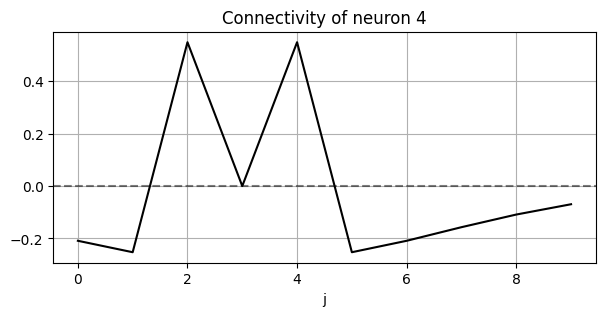

In [383]:
w = mod.mexican_hat_1D(N=N, A=1.45, B=.085, sigma_exc=.525, sigma_inh=3.5)

net.set_wrec(w)
#mv.plot_weight_matrix(net.Wrec)

plt.figure(figsize=(7, 3))
plt.axhline(0, color="black", alpha=0.5, linestyle='--')
plt.plot(range(N), net.Wrec[3], '-k')
plt.title("Connectivity of neuron 4")
plt.xlabel("j")
plt.grid()
plt.show()

## Simulation

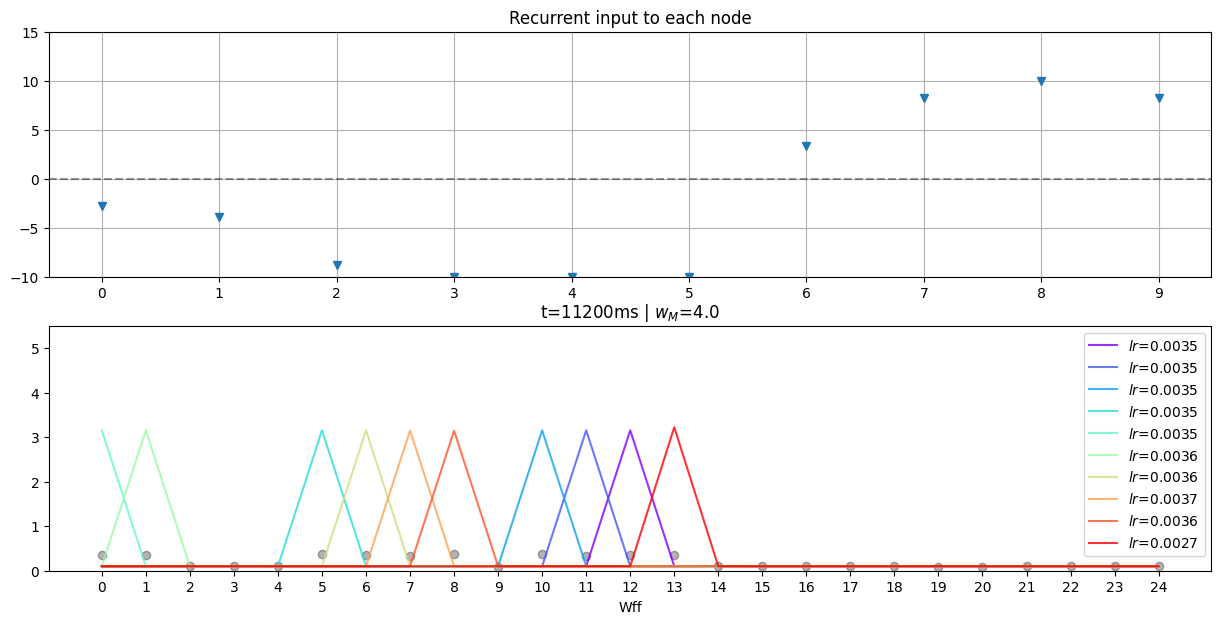

.


In [384]:
net.reset()

tp = 400

sp = np.zeros(Nj)
for t in range(T):

    net.step(Sj=Sj[t])
    sp += Sj[t, :, 0]

    #plt.clf()
    if t%tp == 0:
        clf()
        fig = plt.figure(figsize=(15, 7))

        plt.subplot(211)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 1], 'v')
        plt.ylim((-10, 15))
        plt.grid()
        plt.xticks(range(N))
        plt.title("Recurrent input to each node")

        plt.subplot(212)
        plt.plot(range(Nj), sp / (t+1) * 10, 'ok', alpha=0.3)

        for i in range(N):
            plt.plot(range(Nj), net.Wff[i], alpha=0.8, color=net.colors[i],
                     label=f"$lr$={net._lr[i, 0]:.4f}")
        plt.xlabel("Wff")
        plt.title(f"t={t+tp}ms | $w_M$={net.wff_max}")
        plt.ylim((0, 5.5))
        plt.xticks((range(Nj)))
        plt.legend(loc="upper right")
        plt.pause(0.01)

print(".")

# Connectivity
---

**1D**

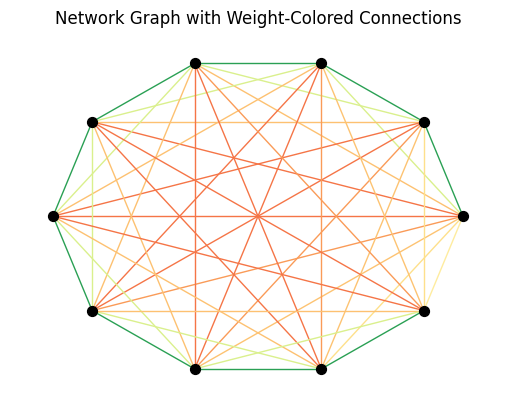

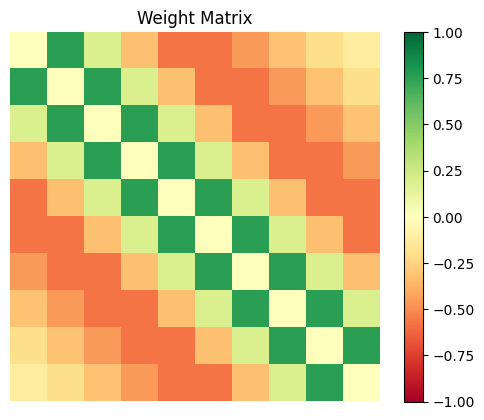

In [44]:
# Generate the Mexican hat connectivity pattern for the smaller network
w = mod.mexican_hat_1D(N=10, A=2.5, B=1.5, sigma_exc=2, sigma_inh=4.)

# plot
mv.plot_graph_colored_1D(w)
mv.plot_weight_matrix(w)

**2D**

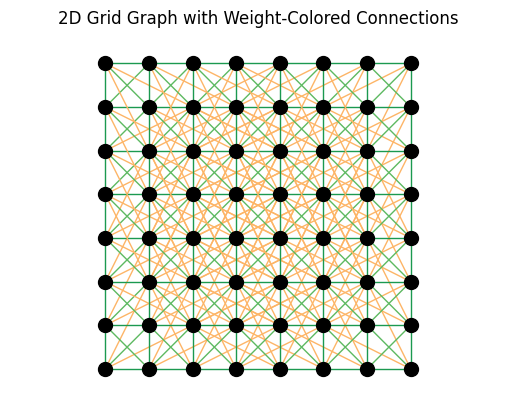

In [72]:
# Define a smaller network for clearer visualization
dims = (8, 8)
A = 2.  # Excitatory strength
B = 1.  # Inhibitory strength
sigma_exc = 2.0  # Excitatory spread
sigma_inh = 4.0  # Inhibitory spread

# Generate the Mexican hat connectivity pattern for the smaller network
w = mod.mexican_hat_2D(dims, A, B, sigma_exc, sigma_inh)

# plot
mv.plot_graph_colored_2D(w, dims, threshold=0.37)

In [294]:
soft = lambda x, b: np.exp(b*x) / np.exp(b*x).sum(axis=0)

In [307]:

sw = soft(w, b=0.05)
print(w, '\n\nsoftmax:\n', np.around(sw, 3), '\n\nmultiplers:\n', sw / sw.max(axis=0))

[[0.        0.        2.        0.        0.       ]
 [0.        0.        0.        0.        2.       ]
 [0.2657752 0.        1.7342248 0.        0.       ]] 

softmax:
 [[0.332 0.333 0.346 0.333 0.322]
 [0.332 0.333 0.313 0.333 0.356]
 [0.336 0.333 0.341 0.333 0.322]] 

multiplers:
 [[0.98679915 1.         1.         1.         0.90483742]
 [0.98679915 1.         0.90483742 1.         1.        ]
 [1.         1.         0.98679915 1.         0.90483742]]


In [278]:
sw / sw.max(axis=0) * w

array([[0.        , 0.        , 2.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 2.        ],
       [0.2657752 , 0.        , 1.32947658, 0.        , 0.        ]])

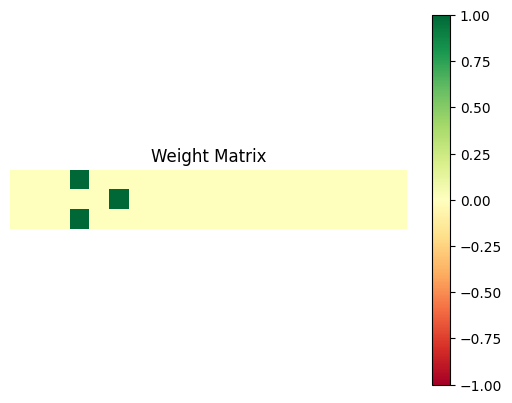

In [233]:
mv.plot_weight_matrix(net.Wff)